In [1]:
! pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 8.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "

# Imports

In [2]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import torch.optim as optim
from datasets import load_dataset
import tqdm
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from huggingface_hub import notebook_login
from collections import Counter
import re

In [3]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [4]:
notebook_login()

# Dataset

## Download dataset

In [5]:
dataset = load_dataset("imdb")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

## show dataset

In [6]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


In [7]:
print(dataset["train"][0]['text'])
print(dataset["train"][0]['label'])

I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, eve

## Index to label

In [8]:
idx2label = {0: "Negative", 1: "Positive"}

In [9]:
dataset["train"] = dataset["train"].map(lambda x: {"label_name": idx2label[x["label"]]})
dataset["test"] = dataset["test"].map(lambda x: {"label_name": idx2label[x["label"]]})

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

## Show class distribution

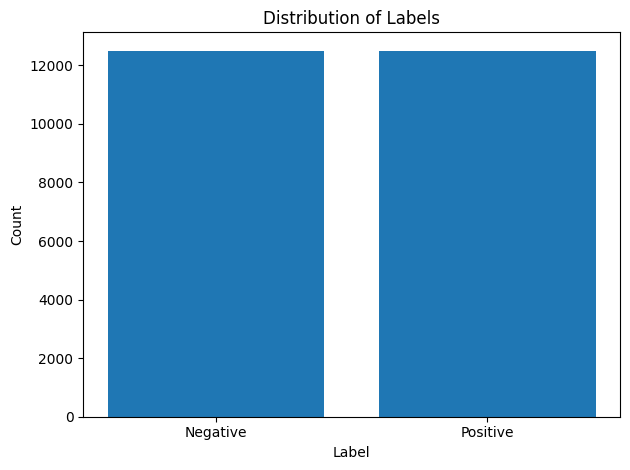

In [10]:
label_counts = Counter(dataset['train']['label_name'])
labels = list(label_counts.keys())
counts = list(label_counts.values())


plt.bar(labels, counts)
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

## Preprocessing

### Remove HTML tags

In [11]:
def remove_html(text):
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

### Tokenize and remove stop words

In [12]:
stop_words = set(stopwords.words('english'))

In [13]:
def tokenize_and_remove_stopwords(example):
    tokens = word_tokenize(example['text'])
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    example['tokens'] = filtered_tokens[:200]
    return example

### Preprocessing function

In [14]:
def preprocess(example):
    example['text'] = remove_html(example['text'])
    example = tokenize_and_remove_stopwords(example)
    return example

### Apply preprocesing

In [15]:
dataset = dataset.map(preprocess)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [16]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_name', 'tokens'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label', 'label_name', 'tokens'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label', 'tokens'],
        num_rows: 50000
    })
})

### Get Sequence lengths

In [17]:
dataset["train"] = dataset["train"].map(lambda x: {"len": len(x['tokens'])})

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [18]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_name', 'tokens', 'len'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label', 'label_name', 'tokens'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label', 'tokens'],
        num_rows: 50000
    })
})


## build vocab

In [19]:
all_tokens = [token for example in dataset['train'] for token in example['tokens']]
vocab_counter = Counter(all_tokens)
vocab = {'<PAD>': 0, '<UNK>': 1}
vocab.update({token: idx + 2 for idx, (token, _) in enumerate(vocab_counter.most_common(20000))})

In [20]:
vocab_size = len(vocab)
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 20002


## tokens to ids

In [21]:
def tokens_to_ids(example):
    example['input_ids'] = [vocab.get(token, vocab['<UNK>']) for token in example['tokens']]
    return example

dataset = dataset.map(tokens_to_ids)


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

## Show sequence length distribution

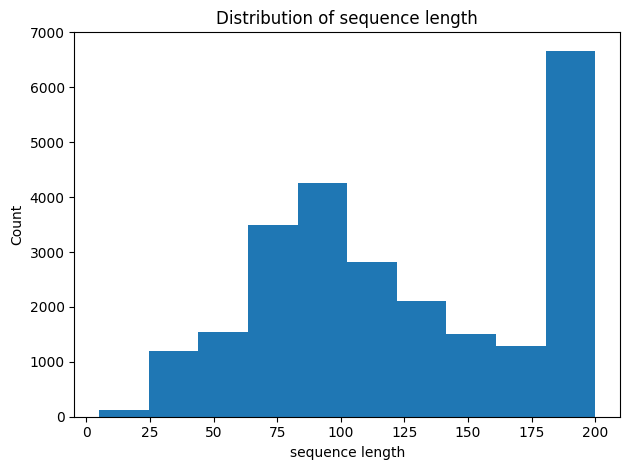

In [22]:
plt.hist(dataset['train']['len'])
plt.title('Distribution of sequence length')
plt.xlabel('sequence length')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

## Dataset class

In [23]:
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self, idx):
        item = self.dataset[idx]
        return torch.tensor(item['input_ids']), item['label'], item['len']

In [24]:
def collate_fn(batch):
    input_ids, labels, lengths_list = zip(*batch)

    lengths = torch.tensor(lengths_list)
    labels = torch.tensor(labels)


    lengths, idx = lengths.sort(descending=True)
    input_ids = [input_ids[i] for i in idx]
    labels = labels[idx]

    padded_inputs = pad_sequence(input_ids, batch_first=True, padding_value=vocab['<PAD>'])

    return padded_inputs, labels, lengths

In [25]:
train_dataset = SentimentDataset(dataset['train'])
test_dataset = SentimentDataset(dataset['test'].select(range(1000)))

## Dataloaders

In [26]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, num_workers=2, shuffle=True, collate_fn=collate_fn)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

# LSTM model class

In [27]:
class SentimentClassifier(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout, pad_idx):
    super().__init__()
    self.embed = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
    self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout= dropout if bidirectional else 0, batch_first=True)
    self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(dropout)
  def forward(self, text, lengths):
      embedded = self.embed(text)
      packed = pack_padded_sequence(embedded, lengths, batch_first=True)
      packed_output, (hidden, cell) = self.lstm(packed)

      if self.lstm.bidirectional:
          hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
      else:
          hidden = hidden[-1]

      hidden = self.dropout(hidden)
      hidden = self.relu(hidden)
      return self.fc(hidden)


# Training loop

In [28]:
def training_loop(model, train_loader, optimizer, criterion, epochs, device):
    model.train()
    losses = []
    accuracies = []

    for epoch in range(epochs):
        running_loss = 0.0
        progress_bar = tqdm.tqdm(train_loader, desc=f"Epoch {epoch + 1} / {epochs} ")
        for inputs, labels, lengths in progress_bar:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs, lengths)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct = (preds == labels).sum().item()
            accuracy = correct / labels.size(0)
            accuracies.append(accuracy)

            avg_loss = running_loss / (progress_bar.n + 1)
            losses.append(avg_loss)
            progress_bar.set_postfix(loss=f"{avg_loss:.4f}", accuracy=f"{accuracy:.4f}")
    return losses, accuracies

# Model Training

## Hyperparameters

In [29]:
embedding_dim = 100
hidden_dim = 256
pad_idx = vocab['<PAD>']
output_dim = 2

### Model 1
- uni direction
- 1 layer

In [30]:
n_layers = 1
bidirectional = False
dropout = 0.5


In [31]:
model = SentimentClassifier(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout, pad_idx)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
epochs = 10

In [32]:
losses_1, accuracies_1 = training_loop(model,
                                   train_loader,
                                   optimizer,
                                   criterion,
                                   epochs,
                                   device)

Epoch 3 / 10 :  35%|███▌      | 554/1563 [08:20<15:11,  1.11it/s, accuracy=0.8750, loss=0.2701]


KeyboardInterrupt: 

### Model 2
- bi-directional
- 1 layer

In [ ]:
n_layers = 1
bidirectional = True
dropout = 0.5

In [ ]:
model = SentimentClassifier(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout, pad_idx)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
epochs = 10

In [ ]:
losses_2, accuracies_2 = training_loop(model,
                                   train_loader,
                                   optimizer,
                                   criterion,
                                   epochs,
                                   device)

### Model 3
- uni direction
- 2 layer

In [ ]:
n_layers = 2
bidirectional = False
dropout = 0.5


In [ ]:
model = SentimentClassifier(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout, pad_idx)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
epochs = 10

In [ ]:
losses_3, accuracies_3 = training_loop(model,
                                   train_loader,
                                   optimizer,
                                   criterion,
                                   epochs,
                                   device)

# Results